In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ArtistAnimation
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm

# XOR - Formulate

In [2]:
xor = {
      (0, 0): 0,
      (0, 1): 1,
      (1, 0): 1,
      (1, 1): 0,
       }

In [3]:
x = np.array([0, 1])
y = np.array([0, 1])

xi, yi = np.meshgrid(x, y)
xi = xi.flatten()
yi = yi.flatten()

z = np.array([xor.get((i, j)) for i, j in zip(xi, yi)])
# z = [xor(i, j) for i, j in ]

In [4]:
xi, yi, z

(array([0, 1, 0, 1]), array([0, 0, 1, 1]), array([0, 1, 1, 0]))

In [5]:
z == 0

array([ True, False, False,  True])

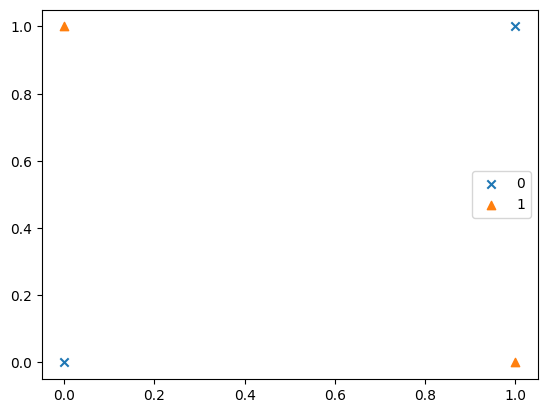

In [6]:
plt.scatter(xi[z == 0], yi[z == 0], marker="x")
plt.scatter(xi[z == 1], yi[z == 1], marker="^")
plt.legend(["0", "1"])
plt.show()

# Dataset

In [7]:
for i in zip(xi, yi):
  print(i)

(0, 0)
(1, 0)
(0, 1)
(1, 1)


In [8]:
np.stack([xi, yi], axis=-1)

array([[0, 0],
       [1, 0],
       [0, 1],
       [1, 1]])

In [9]:
class XORDataset(Dataset):
  def __init__(self):
    super().__init__()
    self.source = torch.Tensor([[0,0], [0,1], [1,0], [1,1]])
    self.target = torch.Tensor([0, 1, 1, 0]).view(-1,1)

  def __len__(self):
    return len(self.source)

  def __getitem__(self, index):
    torch.randn
    return self.source[index], self.target[index]


In [10]:
dataset = XORDataset()

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Model define

In [11]:
class XOR(nn.Module):
  def __init__(self):
    super().__init__()

    self.stack = nn.Sequential(
        nn.Linear(2, 5),
        nn.Softplus(),
        nn.Linear(5, 1)
    )

  def forward(self, x):
    return self.stack(x)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cuda


# Training loop

In [13]:
@torch.no_grad()
def xor_pred():
  x = np.arange(-0.5, 1.5, 0.01, dtype=np.float32)
  y = np.arange(-0.5, 1.5, 0.01, dtype=np.float32)

  xx, yy = np.meshgrid(x, y)

  # xx = xx.flatten()
  # yy = yy.flatten()

  xy = torch.from_numpy(np.stack([xx.flatten(), yy.flatten()], axis=-1)).to(device)
  pred = model(xy).sigmoid().to('cpu').numpy()
  zz = pred.reshape(xx.shape)
  return xx, yy, zz

In [14]:
seed = 128
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [15]:
model = XOR()
model.to(device)

optimizer = Adam(model.parameters())
crit = nn.BCEWithLogitsLoss().to(device)

In [16]:
def create_frame(step, ax):
    ax.cla()
    plt.contourf(xx, yy, zz)
    plt.scatter(xi[z == 0], yi[z == 0], marker="x", label='0')
    plt.scatter(xi[z == 1], yi[z == 1], marker="^", label='1')
    plt.legend()

In [17]:
n_epochs = 10_000

training_loss = []
contours = []
for epoch in tqdm(range(n_epochs)):
  epoch_loss = 0
  for source, target in dataloader:
    noise_ = torch.normal(
        0,
        torch.exp(-torch.tensor(0.01*epoch)),
        size=source.shape,
        device=device) # noise with variance schedule to make good fit

    source = source.to(device) + noise_
    target = target.to(device)
    # forward pass
    logits = model(source)
    loss = crit(logits, target)

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    epoch_loss += loss.item()
  contours.append(xor_pred())

  training_loss.append(epoch_loss/4)

100%|██████████| 10000/10000 [00:44<00:00, 224.00it/s]


In [18]:
with torch.no_grad():
  print(model(torch.Tensor([[0,0],[0,1], [1,0], [1,1]]).to(device)).sigmoid().round())

tensor([[0.],
        [1.],
        [1.],
        [0.]], device='cuda:0')


# Visualization and testing

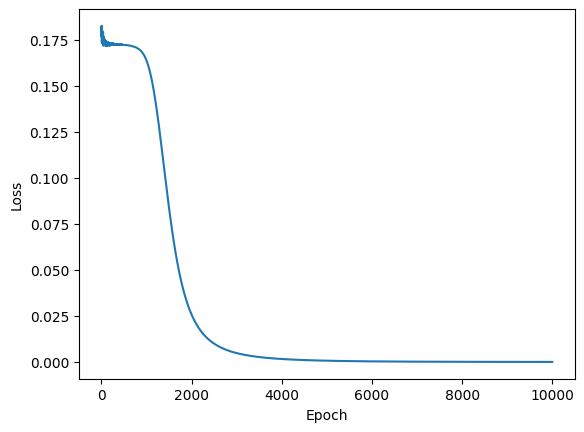

In [19]:
plt.plot(training_loss)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [20]:
xx, yy, zz = contours[-1]

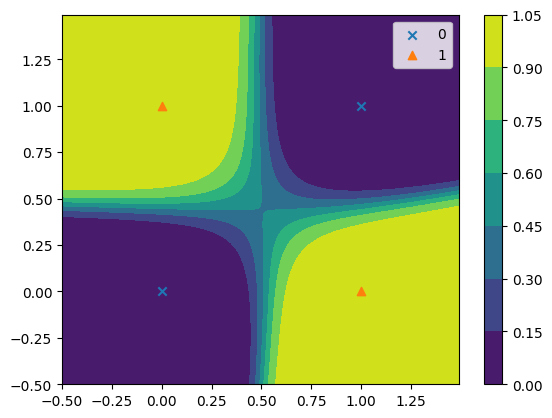

In [21]:
plt.figure()
plt.contourf(xx, yy, zz)
plt.colorbar()
plt.scatter(xi[z == 0], yi[z == 0], marker="x", label='0')
plt.scatter(xi[z == 1], yi[z == 1], marker="^", label='1')
plt.legend()
plt.show()

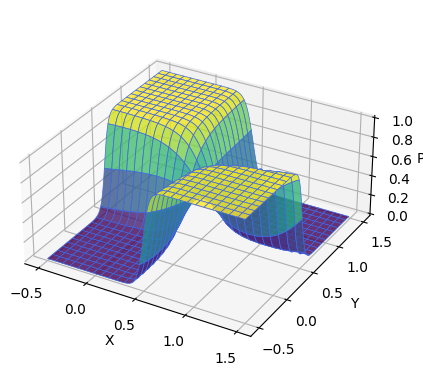

In [22]:
ax = plt.figure().add_subplot(projection='3d')

# Plot the 3D surface
ax.plot_surface(xx, yy, zz, edgecolor='royalblue', cmap='viridis', lw=0.5, rstride=8, cstride=8,
                alpha=0.8)

ax.set(xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), zlim=(-0.5, 1.5),
       xlabel='X', ylabel='Y', zlabel='Pred')
plt.axis('image')
plt.show()


In [23]:
# fig = plt.figure()
# ims = []
# for i in tqdm(range(0, n_epochs, 100)):
#     xx, yy, zz = contours[i]
#     im = plt.contourf(xx, yy, zz)
#     ims.append(im)
# # cbar = plt.colorbar(im)
# # cbar.set_clim(0, 1)
# # cbar.set_ticks(np.linspace(0, 1, 0.1))
# # cbar.set_label('Sigmoid activation')

# # plt.xlim(-0.5, 1.5)
# # plt.ylim(-0.5, 1.5)
# plt.axes().set_aspect('equal')

In [24]:
# ani = ArtistAnimation(fig, ims, interval=20, repeat=True)
# ani

In [25]:
# ani

In [26]:
# ani.save('contour.mp4', writer='ffmpeg')

In [27]:
import plotly.graph_objects as go

fig = go.Figure(go.Surface(
    contours = {
        # "x": {"show": True, "start": -0.5, "end": 1.5, "size": 0.04, "color":"white"},
        # "y": {"show": True, "start": -0.5, "end": 1.5, "size": 0.05, "color":"red"},
        "z": {"show": True, "start": -0.5, "end": 1.5, "size": 0.05, "color":"green"},
    },
    x = xx,
    y = yy,
    z = zz
    ))
fig.update_layout(
        scene = {
            "xaxis": {"nticks": 20},
            "zaxis": {"nticks": 4},
            'camera_eye': {"x": 0, "y": -1, "z": 0.5},
            "aspectratio": {"x": 1, "y": 1, "z": 0.2}
        })
fig.show()

In [28]:
from matplotlib.animation import FuncAnimation

# fig, ax = plt.subplots(1, 1, projection='3d')
fig = plt.figure()
ax = plt.axes(projection='3d')
# fig.set_size_inches(2,2)

def animate(i):
    ax.clear()
    # Get the point from the points list at index i
    xx, yy, zz = contours[i]
    # Plot that point using the x and y coordinates
    ax.plot_surface(xx, yy, zz, edgecolor='royalblue', cmap='viridis', lw=0.5, rstride=8, cstride=8,
                    alpha=0.8)
    # Set the x and y axis to display a fixed range
    ax.set(xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), zlim=(-0.5, 1.5),
            xlabel='X', ylabel='Y', zlabel='Pred', title=f'Epoch:{i}')
ani = FuncAnimation(fig, animate, frames=range(0, len(contours), 50),
                    interval=100, repeat=True)
plt.close()

In [29]:
from matplotlib.animation import PillowWriter
# Save the animation as an animated GIF
ani.save("simple_animation.gif", dpi=50,
        writer=PillowWriter(fps=30))